In [293]:
import fastf1 as f
import fastf1.plotting as p
import numpy as np
import pandas as pd 
from matplotlib import rcParams, pyplot as plt
import seaborn as sns 
import os
import tomli
from math import ceil

In [294]:
# connect to cache 
cache_path = os.getcwd() + "/Cache"
f.Cache.enable_cache(cache_path)

In [295]:
# plotting setup
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.style.use("dark_background")

In [296]:
# Suppress SettingWithCopy Warning
pd.options.mode.chained_assignment = None

In [297]:
# read configs
with open("Data/compound_selection.toml", "rb") as toml:
    compound_selection = tomli.load(toml)

with open("Data/visualization_config.toml", "rb") as toml:
    visual_config = tomli.load(toml)

visual_config["fresh_markers"][True] = visual_config["fresh_markers"]["True"]
visual_config["fresh_markers"][False] = visual_config["fresh_markers"]["False"]

# Load Dataframes 

In [298]:
def correct_dtype(df_laps):
    '''
    Requires: 
    df_laps has the following columns: ["Time", "PitInTime", "PitOutTime", "IsPersonalBest"]
    '''

    # convert from object (string) to timedelta
    df_laps[["Time", "PitInTime", "PitOutTime"]] = df_laps[["Time", "PitInTime", "PitOutTime"]].apply(pd.to_timedelta)

    # TrackStatus column makes more sense as strings 
    df_laps["TrackStatus"] = df_laps["TrackStatus"].astype(str)

    return df_laps

In [299]:
def load_laps():
    df_dict = {}
    data_files = [file for file in os.listdir("Data") if os.path.isfile("Data/"+file)]

    for file in data_files:
        if file.startswith("transformed"):
            season = file.split("_")[2]
            season = int(season[:season.find(".")])

            df = pd.read_csv("Data/" + file, header=0, index_col=0, true_values=["True"], false_values=["False"])
            correct_dtype(df)

            df_dict[season] = df

    return df_dict

In [300]:
df_dict = load_laps()

# Visualization Functions

In [301]:
def find_legend_order(labels):
    """
    Given the list of labels, return a list of int that specifies their appropriate order in the legend
    
    e.g. labels = ["MEDIUM", "HARD", "SOFT"]
         desired = ["SOFT", "MEDIUM", "HARD"]
         return [2, 0, 1]
         
         labels = ["C3", "C1", "WET"]
         desired = ["C1", "C3", "WET"],
         return [1, 0, 2]
    """
    
    order = []
    old_indices = list(range(len(labels)))
    sorted_labels = []

    if any([name in labels for name in ["HYPERSOFT", "ULTRASOFT", "SUPERSOFT", "SUPERHARD"]]):
        # 2018 absolute compound names
        sorted_labels = visual_config["absolute"]["labels"]["18"]
    elif any([label.startswith("C") for label in labels]):
        # 19_ absolute compound names
        sorted_labels = visual_config["absolute"]["labels"]["19_"]
    else:
        # default to relative names
        sorted_labels = visual_config["relative"]["labels"]

    pos = [sorted_labels.index(label) for label in labels]
    order = [old_index for sorted_index, old_index in sorted(zip(pos, old_indices))]
    
    return order

In [302]:
def filter_round_driver(df_laps, round_number, drivers):
    """
    Filter by round number and drivers    
    """
    
    df_laps = df_laps[(df_laps["RoundNumber"] == round_number) & (df_laps["Driver"].isin(drivers))]

    return df_laps

In [303]:
def plot_args(season, absolute_compound):
    """
    Given the input argument, return a list of the corresponding arguments to be supplied to the plotting function
    
    Args:
        absolute_compound: bool
            If true, use absolute compound names (C1, C2 ...) in legend
            Else, use relative compound names (SOFT, MEDIUM, HARD) in legend
    
    Returns: tuple
        (hue, palette, marker, labels)
    """    
    if absolute_compound:
        if season == 2018:
            return ("CompoundName",
                    visual_config["absolute"]["palette"]["18"],
                    visual_config["absolute"]["markers"]["18"],
                    visual_config["absolute"]["labels"]["18"]
                    )
        else:
            return ("CompoundName",
                    visual_config["absolute"]["palette"]["19_"],
                    visual_config["absolute"]["markers"]["19_"],
                    visual_config["absolute"]["labels"]["19_"]
                    ) 
    else:
        return ("Compound",
                visual_config["relative"]["palette"],
                visual_config["relative"]["markers"],
                visual_config["relative"]["labels"]
                )

## Tyre Usage

In [304]:
def make_autopct(values):

    def my_autopct(pct):
        total = sum(values)
        
        # additional call to int is for type conversion
        # not duplicated rounding
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)

    return my_autopct

In [305]:
def get_pie_palette(season, absolute, labels):
    if absolute:
        if season == 2018:
            return [visual_config["absolute"]["palette"]["18"][label] for label in labels]
        else:
            return [visual_config["absolute"]["palette"]["19_"][label] for label in labels]
    else:
        return [visual_config["relative"]["palette"][label] for label in labels]


In [306]:
def make_pie_title(season, slick_only):
    if slick_only:
        return f"Slick Compound Usage in the {season} Season"
    else:
        return f"All Compound Usage in the {season} Season"

In [307]:
def tyre_usage_pie(season, title=None, events=None, drivers=None, slick_only=True, absolute_compound=False):
    
    """
    Make tyre usage pie chart that allows filtering by events, drivers, and slick vs wet tyres
    
    Args:
        season: int {2021, 2022}
            Championship season
        
        title: str, default:None
            Use the default argument to get an automatically formatted title
            (Only available when events and drivers are both None)
            
        events: list, default: None
            A list containing the round number (as int) or the names of events
            e.g. [1, "Hungary", "British Grand Prix", "Monza"]
            Name fuzzy matching provided by fastf1.get_event()
            Using the default value will select all events
            
        drivers: list, default:None
            A list containing three-letter driver abbreviations 
            e.g. ["VER", "HAM"]
            Using the default value will select all drivers
            
        slick_only: bool, default:True
            If true, only laps raced on slick tyres are counted
            If false, all laps are counted
            
        absolute_compound: bool, default:False
            If true, group tyres by their absolute compound names (C1, C2 etc.)
            If false, group tyres by their names in the respective events (SOFT, MEDIUM, HARD)
          
    Returns: Figure object
    """    
    included_laps = df_dict[season]

    if title is None and events is None and drivers is None:
        title = make_pie_title(season, slick_only)
    
    if events is None:
        events = pd.unique(included_laps["RoundNumber"])
    else:
        events = [f.get_event(season, event)["RoundNumber"] if isinstance(event, str) else event for event in events]
        
    if drivers is None:
        drivers = pd.unique(included_laps["Driver"])

    if slick_only:
        included_laps = included_laps[included_laps["IsSlick"] == True]


    included_laps = included_laps[(included_laps["RoundNumber"].isin(events)) & (included_laps["Driver"].isin(drivers))]
    
    fig, ax = plt.subplots(figsize=(10,6))
    plt.style.use("default")

    lap_counts = None 
    if absolute_compound:
        lap_counts = included_laps.groupby("CompoundName").size()
    else:
        lap_counts = included_laps.groupby("Compound").size()

    labels = lap_counts.index
    palette = get_pie_palette(season, absolute_compound, labels)
    
    wedges, texts, autotexts = ax.pie(x=lap_counts.values,  
                                        labels=labels, 
                                        colors=palette, 
                                        autopct=make_autopct(lap_counts), 
                                        counterclock=False, 
                                        startangle=90)

    handles, labels = ax.get_legend_handles_labels()
    label_order = find_legend_order(labels)
    ax.legend(handles=[handles[i] for i in label_order],
              labels=[labels[i] for i in label_order], 
              title="Compound Names", 
              loc="best")
              
    ax.axis("equal")
    ax.set_title(title)
    plt.setp(autotexts, size=12)
    plt.show()
    
    return fig

## Driver Stats Scatterplot

In [308]:
def pick_driver_color(driver, team):
    # first try to use FastF1's driver color
    # second fall back to FastF1's team color
    if p.DRIVER_TRANSLATE.get(driver, "NA") in p.DRIVER_COLORS:
        return p.DRIVER_COLORS[p.DRIVER_TRANSLATE[driver]]
    elif team.lower() in p.TEAM_COLORS:
        return p.TEAM_COLORS[team]
    else:
        return "#ffffff"

In [309]:
def fill_freshtyre(df_laps):
    # missing data in the FreshTyres column can cause some rows to be missing from the plot 
    # convert the column to str type first
    # and then fill the missing entries with "UNKNOWN"

    df_laps["FreshTyre"] = df_laps["FreshTyre"].fillna("Unknown")

    return df_laps

In [310]:
def plot_driver_stats(season, event, drivers, y="LapTime", upper_bound=10, absolute_compound=False):
    """
    Plot lap times for selected season, event, and drivers
            
    Args:
        season: int 
            Championship season
            
        event: int or str
            Round number or name of the event
            Name is fuzzy matched by fastf1.get_event()
        
        drivers: list
            List of the three-letter abbreviations of the drivers to be included 
            
        y: str, default: LapTime
            Name of the column to be used as the y-axis.
            
        upper_bound: float, default: 10
            The upper bound of PctFromFastest for the laps to include
            
            If None, upper bound is set to 30. Use this setting for wet races!
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: False
        
    Returns: Figure
    """    
        
    plt.style.use("dark_background")
    fontdict = {'fontsize': rcParams['axes.titlesize'],
                'fontweight': rcParams['axes.titleweight'],
                'color': rcParams['axes.titlecolor'],
                'verticalalignment': 'baseline',
                'horizontalalignment': "center"}

    max_width = 4    
    num_row = ceil(len(drivers) / max_width)
    num_col = len(drivers) if len(drivers) < max_width else max_width
    fig, axes = plt.subplots(nrows=num_row, ncols=num_col, sharey=True, sharex=True, figsize=(5*num_col, 5*num_row))
    
    # Prevent TypeError when only one driver is plotted
    if len(drivers) == 1:
        axes = np.array([axes])

    event_info = f.get_event(season, event)
    round_number = event_info["RoundNumber"]
    event_name = event_info["EventName"]
    
    args = plot_args(season, absolute_compound)    
    included_laps = df_dict[season]
    included_laps = filter_round_driver(included_laps, round_number, drivers)
    included_laps = fill_freshtyre(included_laps)
        
    for i in range(len(drivers)):
        row = i // max_width
        col = i % max_width
        
        ax = axes[row][col] if num_row > 1 else axes[col]
        
        driver_laps = included_laps[included_laps["Driver"]==drivers[i]]

        pit_in_laps = driver_laps[driver_laps["PitInTime"].notnull()]["LapNumber"].to_numpy()
        
        # After pitstops are identified, we can filter out laps that doesn't meet the upper_bound
        driver_laps = driver_laps[driver_laps["PctFromFastest"] < upper_bound]
            
        sns.scatterplot(data=driver_laps, 
                        x="LapNumber", 
                        y=y, 
                        ax=ax, 
                        hue=args[0], 
                        palette=args[1],
                        hue_order=args[3],
                        style="FreshTyre",
                        style_order = [True, False, "Unknown"],
                        markers=visual_config["fresh_markers"],
                        legend='auto' if i == num_col-1 else False
                        )
        
        ax.vlines(ymin=plt.yticks()[0][1], ymax=plt.yticks()[0][-2], x=pit_in_laps, label="Pitstop", linestyle="dashed")

        driver_color = pick_driver_color(drivers[i], driver_laps["Team"].mode())
        fontdict["color"] = driver_color 
        ax.set_title(label=drivers[i], fontdict=fontdict, fontsize=12)
        
        ax.grid(color=driver_color, which='both', axis='both')
        sns.despine(left=True, bottom=True)
                
    fig.suptitle(t="{} {}".format(season, event_name), fontsize=20)
    axes.flatten()[num_col-1].legend(loc='best', fontsize=8, framealpha=0.5)
    plt.show()
    
    return fig

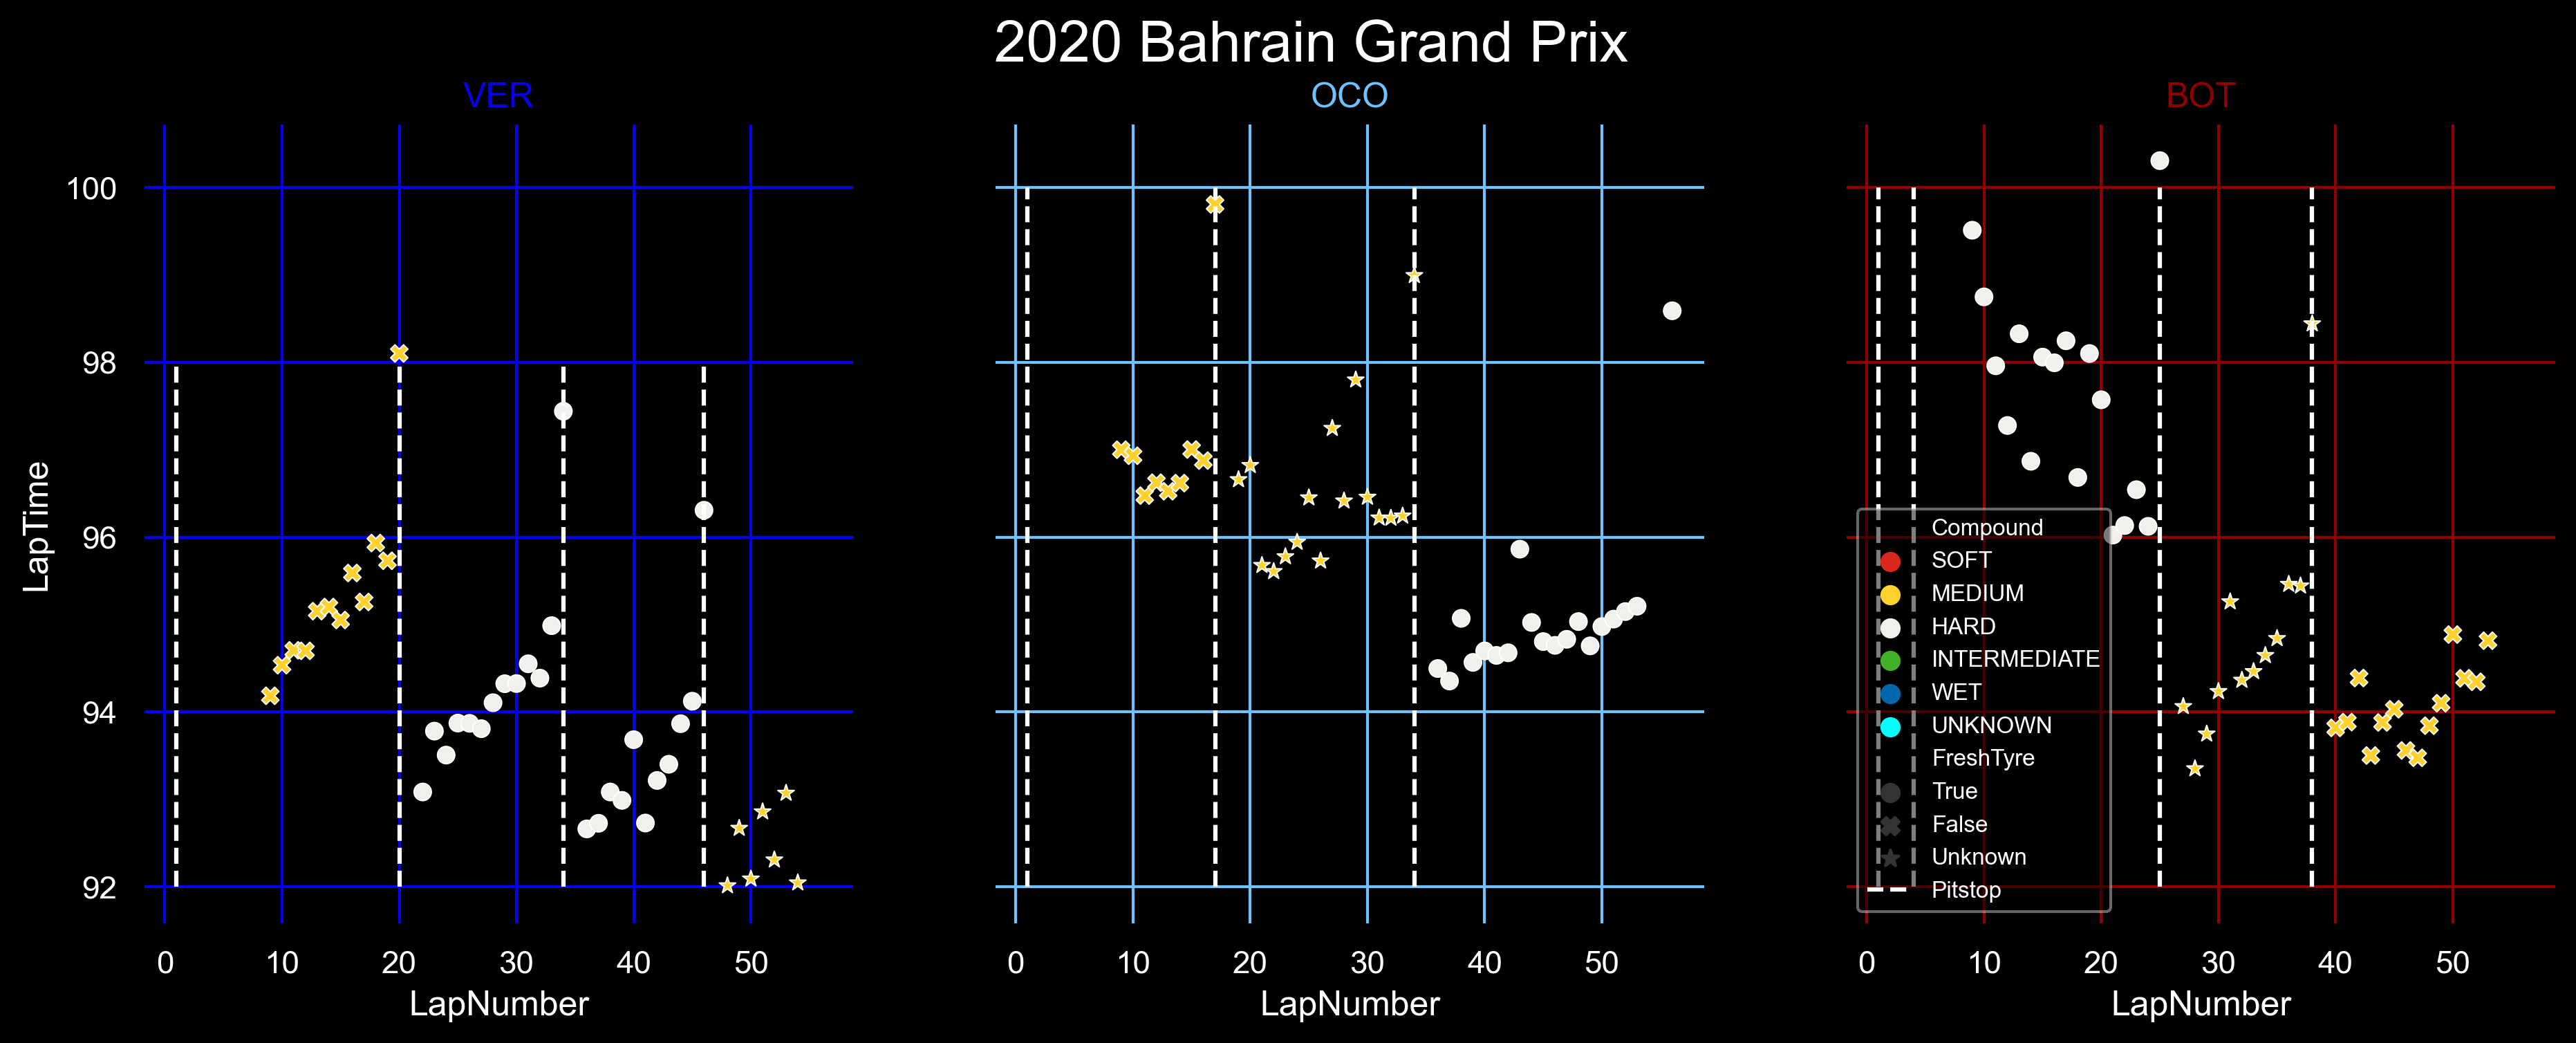

In [311]:
test = plot_driver_stats(season=2020, 
                        event="Sahkir", 
                        drivers=["VER", "OCO", "BOT"], 
                        y="LapTime", 
                        upper_bound=10, 
                        absolute_compound=False)

## Tyre Strategy Barplot

### Tyre Strategy for Selected Drivers

In [ ]:
# WARNING: A row may fall under both categories

def lap_filter_sc(row):
    # if track status column includes 4
    # at least part of the lap is under safety car
    # may slightly overcount
    return "4" in row.loc["TrackStatus"]

def lap_filter_vsc(row):
    # track status = 6 is VSC deployed
    # track status = 7 is VSC ending 
    # check if any part of the lap falls into either category 
    return ("6" in row.loc["TrackStatus"]) or ("7" in row.loc["TrackStatus"])

In [ ]:
def find_sc_laps(df):
    # df should be rows from a single event 
    # at the minimum, both LapNumber and TrackStatus has to be present 

    sc_laps = np.sort(df[df.apply(lap_filter_sc, axis=1)]["LapNumber"].unique())
    vsc_laps = np.sort(df[df.apply(lap_filter_vsc, axis=1)]["LapNumber"].unique())

    return sc_laps, vsc_laps

In [ ]:
def shade_sc_periods(sc_laps, vsc=False):
    # shade SC periods lasting at least one lap on the current figure
    # sc_laps is an array of integers indicating laps under SC or vsc 
    sc_laps_copy = np.append(sc_laps, [-1])

    start = 0
    end = 1 

    while end < len(sc_laps_copy):
        # check if two SC laps are continuous
        if sc_laps_copy[end] == sc_laps_copy[end-1] + 1:
            end += 1
        else:
            # current SC period has ended
            # if the period is at least one full lap 
            if end - start - 1 >= 1:
                # minus one to correct for zero indexing on the plot 
                # but one indexing in the data 
                plt.axvspan(xmin=sc_laps_copy[start]-1, 
                            xmax=sc_laps_copy[end-1]-1,
                            alpha=0.5,
                            color="orange",
                            hatch="xxx" if vsc else None,
                            label="VSC" if vsc else "SC"
                            )
                
            start = end 
            end += 1

    return None

In [ ]:
def plot_strategies_barplot(season, event, drivers=None, absolute_compound=False):
    """
    Plot the tyre strategy for selected season, event, and drivers
            
    Args:
        season: int {2021, 2022}
            Championship season
            
        event: int or str
            Round number or name of the event
            Name is fuzzy matched by fastf1.get_event()
        
        drivers: list, default: None
            List of the three-letter abbreviations of the drivers to be included 
            If None, all drivers are plotted
        
        absolute_compound: bool, default: False
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure
    """    

    event_info = f.get_event(season, event)
    round_number = event_info["RoundNumber"]
    event_name = event_info["EventName"]        
    
    included_laps = pd.DataFrame()
    args = plot_args(absolute_compound)
    
    if season == 2021:
        if drivers == None:
            drivers = df_laps_2021[df_laps_2021["RoundNumber"] == round_number]["Driver"].unique()
        included_laps = df_laps_2021[df_laps_2021.apply(lambda row: lap_filter_round_driver(row, round_number, drivers), axis=1)]
    elif season == 2022:
        if drivers == None:
            drivers = df_laps_2022[df_laps_2022["RoundNumber"] == round_number]["Driver"].unique()
        included_laps = df_laps_2022[df_laps_2022.apply(lambda row: filter_round_driver(row, round_number, drivers), axis=1)]
    else:
        raise ValueError("season requested ({}) not available".format(season))

    fig, ax = plt.subplots(figsize=(5, len(drivers)//2 + 1))    
    plt.style.use("dark_background")

    driver_stints = included_laps[['Driver', 'Stint', "Compound", "CompoundName", "FreshTyre", "LapNumber"]].groupby(['Driver', 'Stint', "Compound", "CompoundName", "FreshTyre"]).count().reset_index()
    driver_stints = driver_stints.rename(columns={"LapNumber":"StintLength"})
    driver_stints = driver_stints.sort_values(by=['Stint'])

    for driver in drivers:
        stints = driver_stints.loc[driver_stints['Driver'] == driver]
        
        previous_stint_end = 0
        for idx, stint in stints.iterrows():
            plt.barh(
                [driver], 
                stint['StintLength'], 
                left=previous_stint_end, 
                color=args[1][stint[args[0]]], 
                edgecolor = "black",
                fill=True,
                hatch=None if stint["FreshTyre"] else "///"
            )
            previous_stint_end += stint['StintLength']

    # shade safety car (both SC and VSC) periods 
    # only safety car lasting at least one full lap will be shown
    # if a lap falls under both category, SC takes precedence
    sc_laps, vsc_laps = find_sc_laps(included_laps)
    vsc_laps = [lap for lap in vsc_laps if lap not in sc_laps]

    shade_sc_periods(sc_laps)
    shade_sc_periods(vsc_laps, vsc=True)

    plt.title("{} {}".format(season, event_name), fontsize=16)
    plt.xlabel('Lap Number')
    plt.grid(False)
    plt.legend(loc="lower right", fontsize=10, )

    # Invert y-axis 
    plt.gca().invert_yaxis()

    # Remove frame from plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()

    return fig

### Compound Head-to-Head Line Chart

In [ ]:
def lap_filter_round_compound_valid_upper(row, round_number, compounds, upper_bound):
    '''
    Filter by round number, whether lap is valid, and compound name
    '''
    return row.loc["RoundNumber"] == round_number and row.loc["IsValid"] and row.loc["Compound"] in compounds and row.loc["PctFromFastest"] < upper_bound

In [ ]:
def convert_compound_names(season, round_number, compounds):
    """
    Convert relative compound names to absolute names 
    
    Args:
        compounds: list of str {"SOFT", "MEDIUM", "HARD", "INTERMEDIATE", "WET"}
    
    Returns:
        comp_names: tuple of str {"C1", "C2", "C3", "C4", "C5", "INTERMEDIATE", "WET"}
        
    """
    compound_to_index = {"SOFT":2, "MEDIUM":1, "HARD":0}
    
    return_value = []
    
    for compound in compounds:
        if compound not in slick_tyre_names:
            return_value.append(compound)
        else:
            if season == 2021:
                return_value.append('C' + str(compound_selection_2021[round_number][compound_to_index[compound]]))
            elif season == 2022:
                return_value.append('C' + str(compound_selection_2022[round_number][compound_to_index[compound]]))
    
    return tuple(return_value)


In [ ]:
def plot_compounds_lineplot(seasons, events, y, compounds=["SOFT", "MEDIUM", "HARD"], x="TyreLife", upper_bound=10, absolute_compound=True):
    """
    Plot lineplot for selected y column by event
        
    Caveats:
        Only laps with IsValid=True are considered
    
    Args:
        seasons: list of int or str
            Championship seasons of the events
        
        events: list of int or str
            A mix of round numbers or names of the events
            Name is fuzzy matched by fastf1.get_event()
        
        Each (season, event) pair should uniquely identify an event
        
        y: str
            The column to use as the y-axis.
        
        compounds: list of str {"SOFT", "MEDIUM", "HARD"}, default: ["SOFT", "MEDIUM", "HARD"]
            The compounds in the head-to-head
            
        x: str {"TyreLife", "LapNumber"} recommended, default: "TyreLife"
            The column to use as the x-axis

        upper_bound: float, default: 10
            The upper bound of PctFromFastest for the laps to include
            
            If None, upper bound is set to 30. Use this setting for wet races!
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: True
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure, Warnings
    """
    
    assert seasons and events and len(seasons) == len(events), "seasons arg size ({}) does not match events arg size ({})".format(len(seasons), len(events))
    
    # unpack
    compounds = [compound.upper() for compound in compounds]
    
    for compound in compounds:
        assert compound in slick_tyre_names, "compound arg {} does not name a slick tyre type".format(compound)
            
    if not absolute_compound:
        print('''
              WARNING: Different events may use different compounds under the same name!
                       e.g. SOFT may be any of C3 to C5 dependinging on the event
              ''')
        
    if x != "LapNumber" and x != "TyreLife":
        print('Using {} as the x-axis is not recommended. The recommended arguments are LapNumber and TyreLife'.format(x))
    
    # Combine seasons and events and get FastF1 event objects
    event_objects = [f.get_event(seasons[i], events[i]) for i in range(len(seasons))]

    plt.style.use("dark_background")
    fig, axes = plt.subplots(nrows=len(event_objects), sharex=True, ncols=1, figsize=(5, 5*len(event_objects)))
    
    # Prevent TypeError when only one event is plotted
    if len(events) == 1:
        axes = [axes]
    
    included_laps_df_list = []
        
    for season, event in zip(seasons, event_objects):
        df_eligible_laps = pd.DataFrame()
        
        if season == 2021:
            df_eligible_laps = df_laps_2021[df_laps_2021.apply(lambda row: lap_filter_round_compound_valid_upper(row, event["RoundNumber"], compounds, upper_bound), axis=1)]
        elif season == 2022:
            df_eligible_laps = df_laps_2022[df_laps_2022.apply(lambda row: lap_filter_round_compound_valid_upper(row, event["RoundNumber"], compounds, upper_bound), axis=1)]
        else:
            raise ValueError("season requested ({}) not available".format(season))

        included_laps_df_list.append(df_eligible_laps)
                
    args = plot_args(absolute_compound)
    
    # Copy compounds values
    # May need to convert from relative to absolute names when plotting
    compounds_copy = compounds

    # store warnings for compounds that are requested but not plotted
    warnings = []
 
    for i in range(len(event_objects)):
        included_laps = included_laps_df_list[i]
        medians = included_laps.groupby([args[0], x])[y].median()
        
        if absolute_compound:
            compounds_copy = convert_compound_names(seasons[i], event_objects[i]["RoundNumber"], compounds)
                            
        for compound in compounds_copy:
            if compound in medians.index:
                ax = sns.lineplot(x=medians.loc[compound].index, 
                                y=medians.loc[compound].values, 
                                ax=axes[i], 
                                color=args[1][compound],
                                marker=args[2][compound],
                                markersize=4,
                                label=compound)
            else:
                warnings.append("{} is not plotted for {} {} because there is no valid lap time data".format(compound, seasons[i], event_objects[i]["EventName"]))

        ax.set_ylabel(y, fontsize=12)
                   
        handles, labels = axes[i].get_legend_handles_labels()
        order = find_legend_order(labels)
        axes[i].legend(handles=[handles[idx] for idx in order], 
                       labels=[labels[idx] for idx in order], 
                       loc="best", 
                       title=args[0],
                       frameon=True,
                       fontsize=10,
                       framealpha=0.5)
        
        ax.set_title(label="{} {}".format(seasons[i], event_objects[i]["EventName"]), fontsize=12)
        ax.grid(which="both", axis='y')
        sns.despine(left=True, bottom=True)
                
    # reorder compound names for title
    compounds = [compounds[i] for i in find_legend_order(compounds)]
    
    fig.suptitle(t=" VS ".join(compounds), fontsize="16")
    plt.show()
    
    return fig, warnings

### Compound Head-to-Head Distribution

In [ ]:
def plot_compounds_distribution(seasons, events, y, compounds=["SOFT", "MEDIUM", "HARD"], violin_plot=False, x="TyreLife", upper_bound=10, absolute_compound=True):
    """
    Plot boxplot for selected y axis by event
        
    Caveats:
        Only laps with IsValid=True are considered
    
    Args:
        seasons: list of int or str
            Championship seasons of the events
        
        events: list of int or str
            A mix of round numbers or names of the events
            Name is fuzzy matched by fastf1.get_event()
        
        (each (season, event) pair should uniquely identify an event)
        
        y: str
            The column to use as the y-axis.
        
        compounds: list of str {"SOFT", "MEDIUM", "HARD"}, default: ["SOFT", "MEDIUM", "HARD"]
            The compounds in the head-to-head

        violin_plot: bool, default: False
            If True, makes violin plots. Else make boxplots
            
        x: str {"TyreLife", "LapNumber"} recommended, default: "TyreLife"
            The column to use as the x-axis

        upper_bound: float, default: 10
            The upper bound of PctFromFastest for the laps to include
            
            If None, upper bound is set to 30. Use this setting for wet races!
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: True
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure, Warnings
    """
    
    assert seasons and events and len(seasons) == len(events), "seasons arg size ({}) does not match events arg size ({})".format(len(seasons), len(events))
    
    compounds = [compound.upper() for compound in compounds]
    
    for compound in compounds:
        assert compound in slick_tyre_names, "compound arg {} does not name a slick tyre type".format(compound)
            
    if not absolute_compound:
        print('''
              WARNING: Different events may use different compounds under the same name!
                       e.g. SOFT may be any of C3 to C5 dependinging on the event
              ''')
    
    if x != "LapNumber" and x != "TyreLife":
        print('Using {} as the x-axis is not recommended. The recommended arguments are LapNumber and TyreLife'.format(x))
    
    # Combine seasons and events and get FastF1 event objects
    event_objects = [f.get_event(seasons[i], events[i]) for i in range(len(seasons))]
    
    included_laps_df_list = []
        
    for season, event in zip(seasons, event_objects):
        df_eligible_laps = pd.DataFrame()
        
        if season == 2021:
            df_eligible_laps = df_laps_2021[df_laps_2021.apply(lambda row: lap_filter_round_compound_valid_upper(row, event["RoundNumber"], compounds, upper_bound), axis=1)]
        elif season == 2022:
            df_eligible_laps = df_laps_2022[df_laps_2022.apply(lambda row: lap_filter_round_compound_valid_upper(row, event["RoundNumber"], compounds, upper_bound), axis=1)]
        else:
            raise ValueError("season requested ({}) not available".format(season))

        included_laps_df_list.append(df_eligible_laps)
                
    args = plot_args(absolute_compound)

    # adjust plot size based on the chosen x-axis
    x_ticks = max([laps[x].nunique() for laps in included_laps_df_list])

    plt.style.use("dark_background")
    fig, axes = plt.subplots(nrows=len(event_objects), sharex=True, ncols=1, figsize=(ceil(x_ticks*0.75), 5*len(event_objects)))
    
    # Prevent TypeError when only one event is plotted
    if len(events) == 1:
        axes = [axes]

    # warnings for compounds that are requested but not plotted
    warnings = []
 
    for i in range(len(event_objects)):
        included_laps = included_laps_df_list[i]

        plotted_compounds = included_laps["Compound"].unique()

        for compound in compounds:
            if compound not in plotted_compounds:
                warnings.append("{} is not plotted for {} {} because there is no valid lap time data".format(compound, seasons[i], event_objects[i]["EventName"]))

        if violin_plot:
            ax = sns.violinplot(data=included_laps,
                                x=x,
                                y=y,
                                ax=axes[i],
                                hue=args[0],
                                palette=args[1])
        else:
            ax = sns.boxplot(data=included_laps,
                             x=x,
                             y=y,
                             ax=axes[i],
                             hue=args[0],
                             palette=args[1])

        ax.set_ylabel(y, fontsize=12)
        xticks = ax.get_xticks()
        xticks = [tick+1 for tick in xticks if tick % 5 == 0]
        ax.set_xticks(xticks)
        ax.grid(which='both', axis='y')
                       
        handles, labels = axes[i].get_legend_handles_labels()
        order = find_legend_order(labels)
        axes[i].legend(handles=[handles[idx] for idx in order], 
                       labels=[labels[idx] for idx in order], 
                       loc="best", 
                       title=args[0],
                       frameon=True,
                       fontsize=10,
                       framealpha=0.5)
        
        ax.set_title(label="{} {}".format(seasons[i], event_objects[i]["EventName"]), fontsize=12)
        sns.despine(left=True, bottom=True)
    
    # reorder compound names for title
    compounds = [compounds[i] for i in find_legend_order(compounds)]
    
    fig.suptitle(t=" VS ".join(compounds), fontsize="16")
    plt.show()
    
    return fig, warnings

## Examples

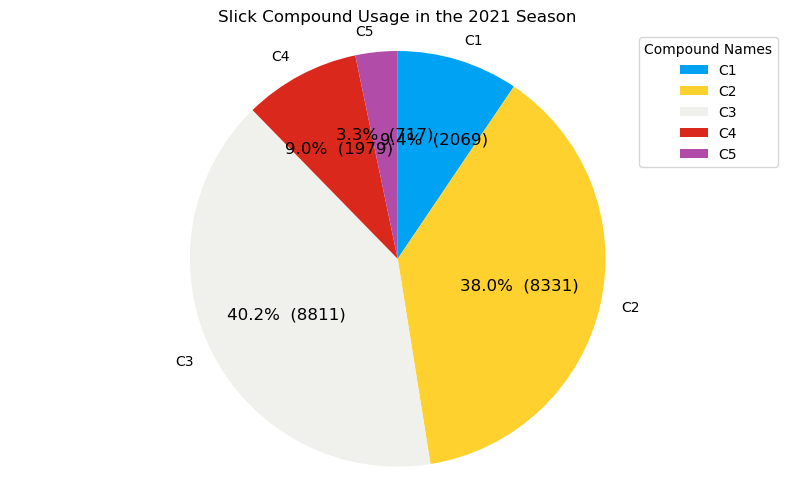

In [15]:
pie_chart = tyre_usage_pie(season=2021, 
                           title="Slick Compound Usage in the 2021 Season", 
                           events=None, 
                           drivers=None, 
                           slick_only=True, 
                           absolute_compound=True)

In [ ]:
lap_time_lineplot = plot_driver_stats(season=2022, 
                                          event="Hungary", 
                                          drivers=["VER", "LEC", "ALO"], 
                                          y="sLapTime", 
                                          upper_bound=10, 
                                          absolute_compound=False)

In [ ]:
tyre_lineplot, warnings = plot_compounds_lineplot(seasons=[2021, 2022], 
                                                  events=["Silverstone", "Silverstone"], 
                                                  y="sDeltaToLapRep", 
                                                  compounds=["MEDIUM", "HARD"], 
                                                  x="TyreLife", 
                                                  upper_bound=10, 
                                                  absolute_compound=True)

In [ ]:
lineplot_with_warnings, warnings = plot_compounds_lineplot([2021, 2022], 
                                                           ["French", "Saudi Arabia"], 
                                                           y="sLapTime")
warnings

In [ ]:
tyre_violinplot, warnings = plot_compounds_distribution(seasons=[2021, 2022], 
                                                        events=["Bahrain", "Bahrain"], 
                                                        y="sLapTime", 
                                                        compounds=["SOFT", "MEDIUM"],
                                                        violin_plot=True,
                                                        x="TyreLife", 
                                                        upper_bound=10, 
                                                        absolute_compound=True)

In [ ]:
tyre_boxplot, warnings = plot_compounds_distribution(seasons=[2022], 
                                                     events=["Brazil"], 
                                                     y="sLapTime", 
                                                     compounds=["SOFT", "MEDIUM"],
                                                     violin_plot=False,
                                                     x="TyreLife", 
                                                     upper_bound=10, 
                                                     absolute_compound=False)

In [ ]:
# some tyre compound data is missing from this grand prix
strategy_barplot = plot_strategies_barplot(2022, "Dutch", drivers=None)